In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import util
from torchsummary import summary
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%load_ext autoreload
%autoreload 2

# %%capture captured

# with open('output.txt', 'w') as f:
#     f.write(captured.stdout)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Get base vectors
# !!! vecs must not be changed

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

vecs = util.fvecs_read("data/siftsmall/siftsmall_learn.fvecs")
query_vecs = util.fvecs_read("data/siftsmall/siftsmall_query.fvecs")
# raise Exception("break")
# shuffle the vectors
np.random.shuffle(vecs)

# Option: reduce the number of vectors
# vecs = vecs[:10000] # vecs.shape= [10000, 128]

# Option: normalize the vectors by min and max value in each dimension
vecs = (vecs - vecs.min(axis=0)) / (vecs.max(axis=0) - vecs.min(axis=0))



In [57]:
def train_0(model, X, Y, epochs=10, batch_size=32):
    assert X.shape[0] == Y.shape[0]
    assert X.shape[1] == 128
    assert len(Y.shape) == 1
    X = torch.from_numpy(X).to(device)
    Y = torch.from_numpy(Y).to(device)
    model = model.to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        test_acc, test_lat, test_loss = test_0_batched(model, test_X, test_y) # test_X, test_y are global variables
        print("acc: {}, latency: {}, test loss: {}".format(test_acc, test_lat, test_loss), end='\t')
        epoch_loss = 0
        for i in range(0, len(X), batch_size):
            optimizer.zero_grad()
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.shape[0]
        epoch_loss /= X.shape[0]
        print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

def test_0_batched(model, X, Y, batch_size=10, device='cuda'):
    """
    Batched testing function.

    Parameters:
    - model: PyTorch model to test
    - X: Input data (numpy array of shape [n_samples, 128])
    - Y: Labels (numpy array with shape [n_samples])
    - batch_size: Size of each batch
    - device: Device on which to run the computations (e.g., 'cuda' or 'cpu')

    Returns:
    - accuracy: Proportion of correctly predicted samples
    - average_latency: Average time taken per sample for prediction
    """
    assert X.shape[0] == Y.shape[0]
    assert X.shape[1] == 128
    assert len(Y.shape) == 1

    model.eval()

    # Convert to PyTorch tensors and move to device
    X = torch.from_numpy(X).to(device)
    Y = torch.from_numpy(Y).to(device)

    correct = 0
    total_latency = 0
    avg_loss = 0
    loss_fn = nn.CrossEntropyLoss()

    num_batches = len(X) // batch_size
    with torch.no_grad():  # Disable gradient computation
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            x_batch = X[start_idx:end_idx]
            y_batch = Y[start_idx:end_idx]

            start_time = time.time()
            
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            avg_loss += loss.item() * x_batch.shape[0]
            # print(torch.nn.functional.softmax(y_pred, dim=1))
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y_batch).sum().item()

            end_time = time.time()
            total_latency += (end_time - start_time)  # Measure time taken for prediction

        # Handle any remaining samples if the dataset size is not a multiple of batch_size
        # if len(X) % batch_size != 0:
        #     x_batch = X[num_batches * batch_size:]
        #     y_batch = Y[num_batches * batch_size:]

        #     start_time = time.time()
            
        #     y_pred = model(x_batch)
        #     loss = loss_fn(y_pred, y_batch)
        #     print(loss)
        #     avg_loss += loss.item() * x_batch.shape[0]
        #     _, predicted = torch.max(y_pred, 1)
        #     correct += (predicted == y_batch).sum().item()

        #     end_time = time.time()
        #     total_latency += (end_time - start_time)  # Measure time taken for prediction

    correct /= batch_size * num_batches
    total_latency /= batch_size * num_batches
    avg_loss /= batch_size * num_batches

    return correct, total_latency, avg_loss


**Experiment 0.0**: Memorize mapping from base points to their own idx (a dictionary)

**Results**: This is trivially done by using a single linear layer. loss tends to zero

**Experiemnt 0.1**: Memorize the cluster boundaries. Which cluster does the query belong to(cluster boundaries)

**Question**: Is this faster than doing distance computation? 

**Results**: 

In [58]:
N_CLUSTERS = 10
N_QUERY = 100000
K = 10
# print(query_vecs.shape)
# raise Exception("break")
X, Y_q_idx, Y_nn_idx, knn_indices = util.generate_query_data_v1(vecs, n_clusters=N_CLUSTERS, n_query=N_QUERY, k=K, random_seed=42)
# X are the query vectors generated
# Y_q_idx is cluster index of each query vector
# Y_nn_idx is the cluster index of knn of the query vector

print(X.shape, Y_q_idx.shape, Y_nn_idx.shape)

class Model_0_1(nn.Module):
    def __init__(self):
        super(Model_0_1, self).__init__()
        self.fc1 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
model = Model_0_1()


train_X, train_y = X[:int(0.8 * N_QUERY)], Y_q_idx[:int(0.8 * N_QUERY)]
test_X, test_y = X[int(0.8 * N_QUERY):], Y_q_idx[int(0.8 * N_QUERY):]

train_0(model, train_X, train_y, epochs=1000, batch_size=50)


KeyboardInterrupt: 

**Experiment 1.0**: Memorize the cluster boudnaries, now predict the cluster of a query's nn instead. 

N_QUERY = 100000
N_CLUSTERS = 10
overlapping = 0.647
batch size = 50
**Results**: 
- Model = single linear layer, acc rises to 0.6549 and doesn't change
- Model = linear 128 128 10, very unstable training, acc rises to 0.6711 and drops!
- Changing batch size to 100, gives more stable drop in training loss. Overall better performance, but still overfits
- Changing N_QUERY to 1000000, this definitely improves performance. 0.6855
- Changing to a much larger model, improves performance to about 0.7, but drops afterwards, clearly overfits


(1000000, 128)
Query cluster vs nn cluster
Ther percentage of query cluster id == -1th nn's cluster id
0.648669
Ther percentage of query cluster id == 0th nn's cluster id
0.638877
Ther percentage of query cluster id == 1th nn's cluster id
0.633095
Ther percentage of query cluster id == 2th nn's cluster id
0.628608
Ther percentage of query cluster id == 3th nn's cluster id
0.625393
Ther percentage of query cluster id == 4th nn's cluster id
0.621572
Ther percentage of query cluster id == 5th nn's cluster id
0.619251
Ther percentage of query cluster id == 6th nn's cluster id
0.617094
Ther percentage of query cluster id == 7th nn's cluster id
0.615121
Ther percentage of query cluster id == 8th nn's cluster id
0.6133
(1000000, 128) (1000000,) (1000000, 10)
acc: 0.08339, latency: 2.4652280807495116e-05, test loss: 2.3055436636328697	Epoch: 0, Loss: 0.8498177528381348
acc: 0.68108, latency: 2.3998942375183106e-05, test loss: 0.8073766212612391	Epoch: 1, Loss: 0.8219229578971863
acc: 0.686185,

KeyboardInterrupt: 

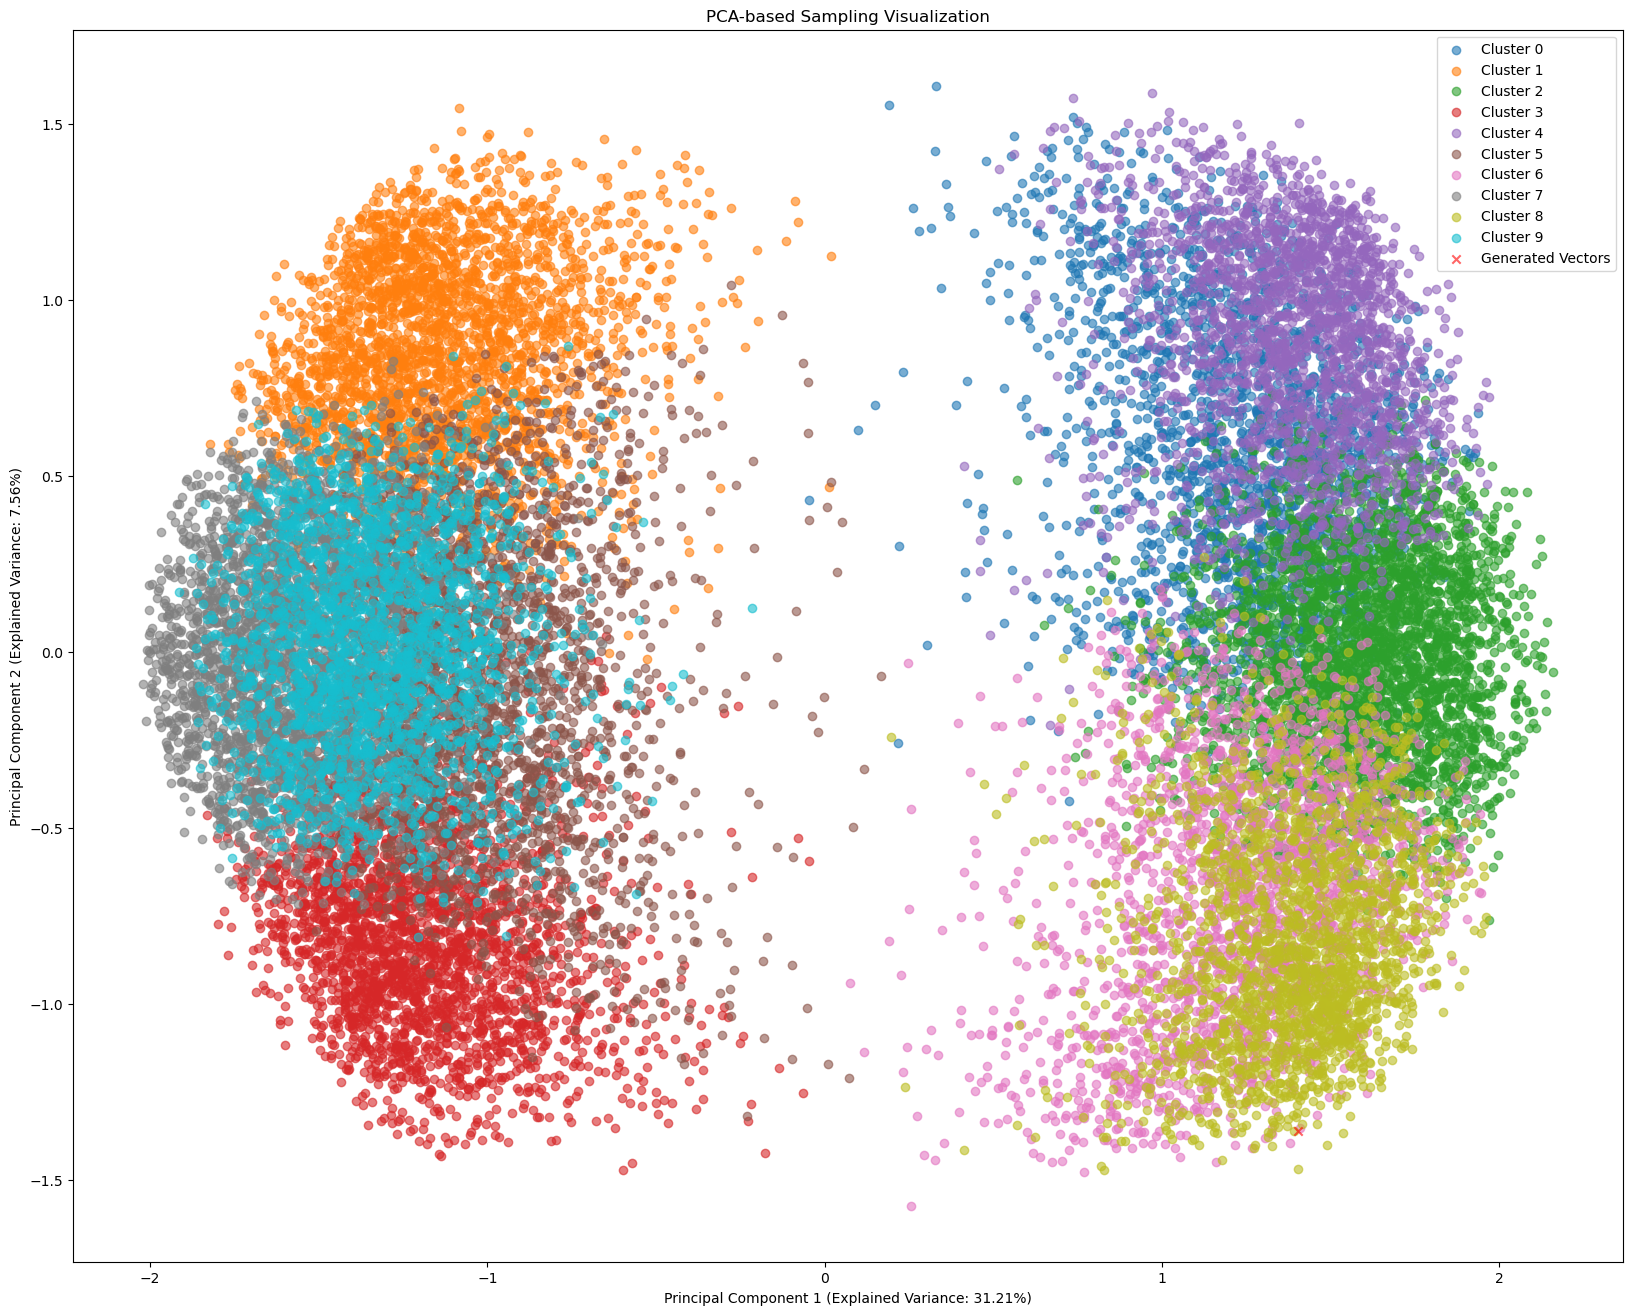

In [60]:
N_CLUSTERS = 10
N_QUERY = 1000000
K = 10
# print(query_vecs.shape)
# raise Exception("break")
X, Y_q_idx, Y_nn_idx, knn_indices = util.generate_query_data_v1(vecs, n_clusters=N_CLUSTERS, n_query=N_QUERY, k=K, random_seed=42)
# X are the query vectors generated
# Y_q_idx is cluster index of each query vector
# Y_nn_idx is the cluster index of knn of the query vector

print(X.shape, Y_q_idx.shape, Y_nn_idx.shape)
# raise Exception("break")
class Model_0_1(nn.Module):
    def __init__(self):
        super(Model_0_1, self).__init__()
        self.fc1 = nn.Linear(128, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.out = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.out(x)
        return x
model = Model_0_1()


train_X, train_y = X[:int(0.8 * N_QUERY)], Y_nn_idx[:int(0.8 * N_QUERY), 0]
test_X, test_y = X[int(0.8 * N_QUERY):], Y_nn_idx[int(0.8 * N_QUERY):, 0]
train_0(model, train_X, train_y, epochs=1000, batch_size=2048)

summary(model, (32, 128))

**Experiment 1.2**: Based on 1.1, but now with unlimited data. 
- Definitely better performance

In [63]:
def train_unlimited(model, clusters, q_nbrs, epochs=10, batch_size=32):
    model.train()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        np.random.seed(epoch)
        query = util.pca_sampling(vecs, N_QUERY, 32, epoch)
        _, indices = q_nbrs.kneighbors(query)
        nn_cluster_idx = clusters[indices]

        X = query
        Y = nn_cluster_idx[:, 0]  # only for the first nearest neighbor now 
        assert X.shape[0] == Y.shape[0]
        assert X.shape[1] == 128
        assert len(Y.shape) == 1
        X = torch.from_numpy(X).to(device)
        Y = torch.from_numpy(Y).to(device)
    # model.train()
    # for epoch in range(epochs):
        test_acc, test_lat, test_loss = test_0_batched(model, test_X, test_y) # test_X, test_y are global variables
        print("acc: {}, latency: {}, test loss: {}".format(test_acc, test_lat, test_loss), end='\t')
        epoch_loss = 0
        for i in range(0, len(X), batch_size):
            optimizer.zero_grad()
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.shape[0]
        epoch_loss /= X.shape[0]
        print("Epoch: {}, Loss: {}".format(epoch, loss.item()))



In [65]:
N_CLUSTERS = 10
N_QUERY = 1000000
K = 1
# print(query_vecs.shape)
# raise Exception("break")
X, Y_q_idx, Y_nn_idx, knn_indices, clusters, q_nbrs = util.generate_query_data_v1(vecs, n_clusters=N_CLUSTERS, n_query=N_QUERY, k=K, random_seed=42)
# X are the query vectors generated
# Y_q_idx is cluster index of each query vector
# Y_nn_idx is the cluster index of knn of the query vector

print(X.shape, Y_q_idx.shape, Y_nn_idx.shape)
# raise Exception("break")
class Model_0_1(nn.Module):
    def __init__(self):
        super(Model_0_1, self).__init__()
        self.fc1 = nn.Linear(128, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.out = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.out(x)
        return x
model = Model_0_1()


train_X, train_y = X[:int(0.8 * N_QUERY)], Y_nn_idx[:int(0.8 * N_QUERY), 0]
test_X, test_y = X[int(0.8 * N_QUERY):], Y_nn_idx[int(0.8 * N_QUERY):, 0]
train_unlimited(model, clusters, q_nbrs, epochs=1000, batch_size=2048)

summary(model, (32, 128))

(1000000, 128) (1000000,) (1000000, 1)
acc: 0.11215, latency: 2.39821982383728e-05, test loss: 2.3018199746727945	Epoch: 0, Loss: 0.8900033235549927
acc: 0.68108, latency: 2.3994914293289184e-05, test loss: 0.8051712558027357	Epoch: 1, Loss: 0.7877316474914551
acc: 0.683485, latency: 2.4203118085861207e-05, test loss: 0.7960190612394362	Epoch: 2, Loss: 0.7967545986175537
acc: 0.688325, latency: 2.501959800720215e-05, test loss: 0.7835022281341255	Epoch: 3, Loss: 0.7864452004432678
acc: 0.69124, latency: 2.4315521717071532e-05, test loss: 0.7725935856886208	Epoch: 4, Loss: 0.7346287369728088
acc: 0.695495, latency: 2.4279160499572755e-05, test loss: 0.762841258592531	Epoch: 5, Loss: 0.7441953420639038
acc: 0.697705, latency: 2.4380214214324952e-05, test loss: 0.7550980301454663	Epoch: 6, Loss: 0.6860186457633972
acc: 0.699305, latency: 2.4275853633880617e-05, test loss: 0.7497777678113431	Epoch: 7, Loss: 0.7196866273880005
acc: 0.701675, latency: 2.408273935317993e-05, test loss: 0.7439